# Modeling and Simulation in Python

Starter code for the orbit example

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [88]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Earth orbiting the sun



In [93]:
# Here are the units we'll need
yr = UNITS.year
s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [94]:
# And an inition condition (with everything in SI units)

r_0 = 147e9 * m
v_0 = -30330 * m/s

init = State(x=r_0, y=0*m, vx=0*m/s, vy=v_0)

,values
x,147000000000.0 meter
y,0 meter
vx,0.0 meter / second
vy,-30330.0 meter / second


In [95]:
# Making a system object

r_earth = 6.371e6 * m
r_sun = 695.508e6 * m
t_year = 1 * yr

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=t_year.to(s))

,values
init,x 147000000000.0 meter y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,31556925.9747 second


In [96]:
# Here's a function that computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x, y, vx, vy = state
    unpack(system)
    
    r= Vector(x,y)
    forceMag = G * m1 * m2 / r.mag**2
    direction= r.hat()
    force = direction*forceMag
    return force

In [97]:
universal_gravitation(init, system)

<Quantity([3.6686486e+22 0.0000000e+00], 'newton')>

In [98]:
# The slope function

def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x, y, vx, vy = state
    unpack(system)    
    r= Vector(x,y)
    force = universal_gravitation(state, system)
    dxdt = vx
    dydt = vy
    dvdtx = -force.x / m2
    dvdty = -force.y / m2
    
    return dxdt, dydt, dvdtx, dvdty

In [99]:
# Always test the slope function!

slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-30330.0, 'meter / second')>,
 <Quantity(-0.006143082049146188, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [100]:
# Here's an event function that stops the simulation
# before the collision

def event_func(state, t, system):
    x, y, vx, vy = state
    r= Vector(x,y)
    return r.mag - system.r_final

In [101]:
# Always test the event function!

event_func(init, 0, system)

<Quantity(146298121000.0, 'meter')>

In [102]:

results, details = run_ode_solver(system, slope_func, events=event_func)
details


,values
sol,None
t_events,[[]]
nfev,152
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [103]:
# Here's how long it takes...

t_final = get_last_label(results) * s

<Quantity(31556925.9747, 'second')>

In [104]:
# ... expressed in units we understand

t_final.to(UNITS.day)

<Quantity(365.24219878124995, 'day')>

In [109]:
# Before plotting, we run the simulation again with `t_eval`

ts = linspace(t_0, t_final, 201)
results, details = run_ode_solver(system, slope_func, events=event_func, method='RK23', t_eval=ts)

In [110]:
# Scaling the time steps to days

results.index /= 60 * 60 * 24

In [111]:
# Scaling the distance to million km

x = results.x / 1e9;
y=results.y /1e9;

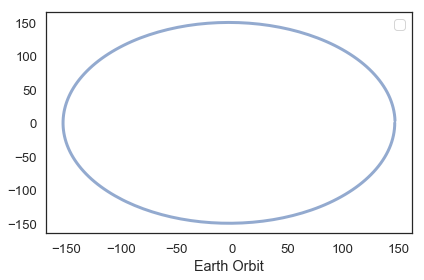

In [112]:
# And plotting

plot(x, y)
decorate(xlabel='Earth Orbit')